In [13]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np

In [57]:
N = 5000

d = np.random.normal(size=N)

epsilon = np.random.normal(size=N)
y = d + epsilon

p_s = 1. / (1. + np.exp(-5.*y))
s = np.random.binomial(1., p=p_s)

X = pd.DataFrame({'D': d, 'Y': y, 'S': s})
X_sampled = X[X['S'] == 1]

In [58]:
X.head()

,D,S,Y
0,-1.153989,0,-0.701370
1,0.073366,0,-0.551148
2,-0.552886,1,0.543580
3,0.041570,0,-0.696925
4,0.568853,0,-0.511785


In [59]:
X_sampled.head()

,D,S,Y
2,-0.552886,1,0.543580
5,0.735751,1,1.265191
6,1.648369,1,1.630948
10,0.348982,1,2.127916
11,1.188942,1,0.481489


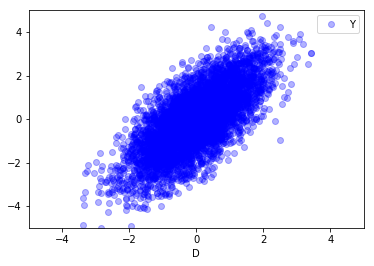

In [60]:
X.plot(x='D', y='Y', style='bo', alpha=0.3, xlim=(-5,5), ylim=(-5, 5))

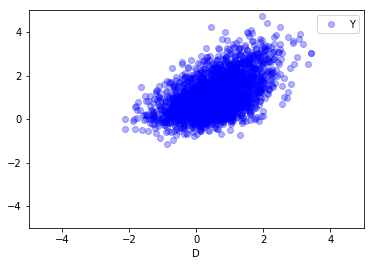

In [63]:
X_sampled.plot(x='D', y='Y', style='bo', alpha=0.3, xlim=(-5,5), ylim=(-5, 5))

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg
import matplotlib.pyplot as pp

Text(0,0.5,'Y')

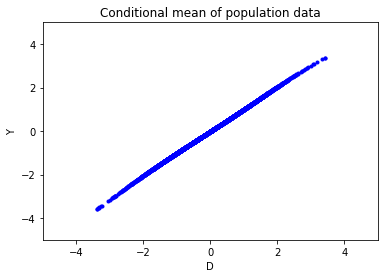

In [76]:
model = KernelReg(X['Y'], X['D'], 'c')
result = model.fit(X['D'])[0]

pp.plot(X['D'], result, 'b.'); pp.xlim(-5,5); pp.ylim(-5,5); pp.title("Conditional mean of population data"); pp.xlabel('D'); pp.ylabel("Y")

Text(0,0.5,'Y')

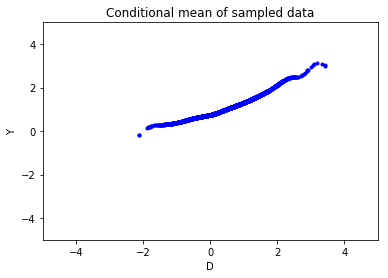

In [77]:
model = KernelReg(X_sampled['Y'], X_sampled['D'], 'c')
result = model.fit(X_sampled['D'])[0]

pp.plot(X_sampled['D'], result, 'b.'); pp.xlim(-5,5); pp.ylim(-5,5); pp.title("Conditional mean of sampled data"); pp.xlabel('D'); pp.ylabel("Y")

## The sampled conditional mean is biased due to conditioning on a descendant of a collider involving an error term!! 

## Now, let's do the estimation for the article translation problem.

In [95]:
d = np.random.choice(range(5), size=N)

q = np.random.normal(d)

y = 100* np.random.normal(q)

p_s = 1. / (1. + np.exp(-(y - 200)/200))
s = np.random.binomial(1, p=p_s)

yt = 100*np.random.normal(q)

X = pd.DataFrame({'D': d, 'Y': y, 'Yt': yt, 'S': s})

In [96]:
X.head()

,D,S,Y,Yt
0,3,1,259.256570,93.277309
1,1,0,-33.135337,298.229415
2,0,0,-57.907072,-76.446788
3,4,1,275.986449,387.190582
4,0,0,6.603954,59.294716


In [97]:
X_sampled = X[X['S'] == 1]

## Now that we have our data, let's compare the sample E[Yt|D] with the population E[Yt|D]. We wouldn't normally be able to make this comparison, but since we generated the data we have the population E[Yt|D].

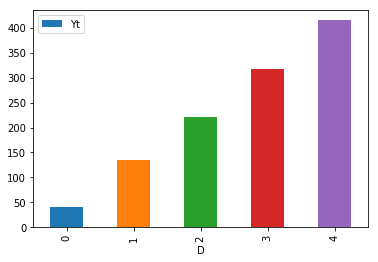

In [103]:
# first the sample means

X_sampled.groupby('D').mean().reset_index().plot(x='D', y='Yt', kind='bar')

In [168]:
X_sampled.groupby('D').mean()[['Yt']]

,Yt
D,
0,40.990550
1,134.658688
2,220.891312
3,316.190018
4,414.573617


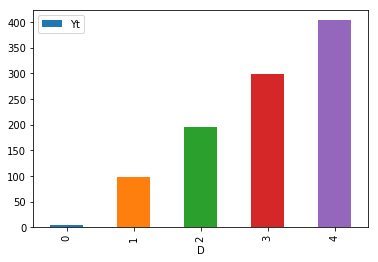

In [101]:
# and now the (usually unmeasured) population means.

X.groupby('D').mean().reset_index().plot(x='D', y='Yt', kind='bar')

In [170]:
X.groupby('D').mean()[['Yt']]

,Yt
D,
0,3.854319
1,97.179741
2,195.800158
3,298.337302
4,402.939388


## We can see there's a good bit of bias in the expected values!

## Now, let's use the estimator to get corrected expectations. 
We want to estimate

$E_{population}[Yt|D] = \sum_{Y}E[Yt|Y, D, S=1]P(Y|D)$, 

or, changing notation slightly, 

$E_{population}[Yt|D] = \sum_{Y}E_{sample}[Yt|Y, D]P_{population}(Y|D)$

But $Y$ is continuous! We actually need to take the integral over $Y$,

$E_{population}[Yt|D] = \int E_{sample}[Yt|Y, D]P_{population}(Y|D) dY$

The problem is actually pretty tricky, since we really need to estimate $P_{population}(Y|D)$ as well. We've only done the binary case until now. Let's tackle the whole problem.

We'll estimate $P_{population}(Y|D)$ with a kernel density estimator, and then actually perform the integral numerically using scipy.

In [183]:
# estimate the density, $P_{population}(Y|D)$

from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional

conditional_model = KDEMultivariateConditional(X['Y'], X['D'], 'c', 'o', 'cv_ml')
conditional_model.pdf(X['Y'], X['D'])

/home/akelleh/.virtualenvs/data/lib/python3.5/site-packages/statsmodels/nonparametric/kernel_density.py:477: RuntimeWarning: invalid value encountered in log
  L += func(f_i)


array([0.00279812, 0.00184942, 0.00245432, ..., 0.00260634, 0.00248156,
       0.00238504])

In [184]:
p_y_given_d = conditional_model.pdf(X['Y'], [0.]*len(X))

Text(0.5,1,'Conditional Density Plot for P(Y|D=0)')

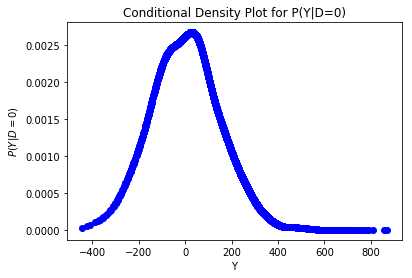

In [185]:
pp.plot(X['Y'], p_y_given_d, 'bo'); pp.xlabel('Y'); pp.ylabel('$P(Y|D=0)$'); pp.title("Conditional Density Plot for P(Y|D=0)")

Text(0.5,1,'Conditional Density Plot for P(Y|D=4)')

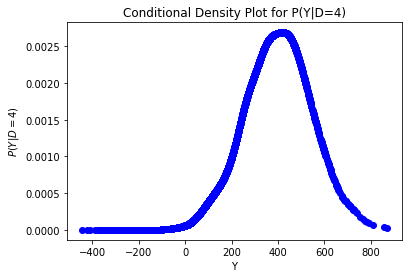

In [186]:
p_y_given_d = conditional_model.pdf(X['Y'], [4.]*len(X))
pp.plot(X['Y'], p_y_given_d, 'bo'); pp.xlabel('Y'); pp.ylabel('$P(Y|D=4)$'); pp.title("Conditional Density Plot for P(Y|D=4)")

## The conditional plots look pretty good!

Now that we have $P_{population}(Y|D)$, we need the expected value, $E_{sample}[Yt|Y, D]$. It's linear, so let's just use a linear model.

In [187]:
from sklearn.linear_model import LinearRegression

expectation_model = LinearRegression()
expectation_model = expectation_model.fit(X_sampled[['Y', 'D']], X_sampled['Yt'])

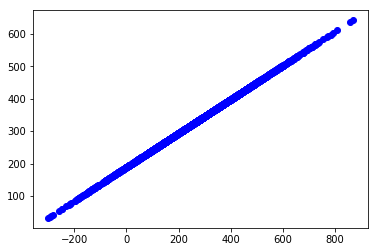

In [188]:
df = X_sampled.copy()
df['D'] = 4
E_yt_given_d_x = expectation_model.predict(df[['Y', 'D']])
pp.plot(df['Y'], E_yt_given_d_x, 'bo')

## Time to integrate!

Again, we're estimating 
$E_{population}[Yt|D] = \int E_{sample}[Yt|Y, D]P_{population}(Y|D) dY$

For more reference on the integrator, check out https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad

The arguments are the integrand (a function), and the upper and lower bounds for the integration. We'll integrate from the min to the max of the observed Y values.



In [189]:
from scipy.integrate import quad

y_min = X['Y'].min()
y_max = X['Y'].max()

def integrand(Y, D):
    return (expectation_model.predict([[Y, D]]) * conditional_model.pdf([Y], [D]))[0]

In [190]:
integrand(100, 0)

0.12613300982650508

In [193]:
D = 4
quad(integrand, y_min, y_max, args=(D,))

(398.51751760868905, 2.897577824563231e-06)